In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
dataset=pd.read_csv("thyroid_cancer_risk_data.csv")
dataset.drop(['Patient_ID', 'Ethnicity'], axis=1, inplace=True)

In [2]:
risk_map = {'Low': 0, 'Medium': 1, 'High': 2}
dataset['Thyroid_Cancer_Risk'] = dataset['Thyroid_Cancer_Risk'].map(risk_map)
dataset=pd.get_dummies(dataset,drop_first=True,dtype=int)
dataset

,Age,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Gender_Male,Country_China,Country_Germany,Country_India,...,Country_South Korea,Country_UK,Country_USA,Family_History_Yes,Radiation_Exposure_Yes,Iodine_Deficiency_Yes,Smoking_Yes,Obesity_Yes,Diabetes_Yes,Diagnosis_Malignant
0,66,9.37,1.67,6.16,1.08,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,29,1.83,1.73,10.54,4.05,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,86,6.26,2.59,10.57,4.61,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,75,4.10,2.62,11.04,2.46,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,35,9.10,2.11,10.71,2.11,2,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,58,2.00,0.64,11.92,1.48,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
212687,89,9.77,3.25,7.30,4.46,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
212688,72,7.72,2.44,8.71,2.36,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
212689,85,5.62,2.53,9.62,1.54,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
dataset.to_csv("thyroid_cancer_risk_encoded.csv", index=False)

In [4]:
# Input & Output datasets
indep=dataset[["Thyroid_Cancer_Risk","TSH_Level","T4_Level","Nodule_Size","T3_Level"]]
dep=dataset["Diagnosis_Malignant"]
dep.value_counts()

0    163196
1     49495
Name: Diagnosis_Malignant, dtype: int64

In [5]:
# Class sample distribution
# Dataset is imbalanced (i.e) benign(0) -- 77% and Malignant (1) -- 23% ---> Data is not balanced
# model can get high accuracy just by predicting “Benign” most of the time.
# To overcome this --> Use class_weight = 'balanced' inside RandomForest

# 1. Using Class_weight Parameter

In [6]:
#split into training set and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(indep, dep, test_size = 1/3, random_state = 0) 


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_ = sc.fit_transform(X_train)
X_test_ = sc.transform(X_test)

In [7]:
# Build and Train Random Forest Model

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(class_weight='balanced',n_estimators = 200, criterion = 'entropy', random_state = 42)
classifier.fit(X_train_, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=200, random_state=42)

In [8]:
# Make Predictions
y_pred = classifier.predict(X_test_)

In [9]:
# Evaluate Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Baseline Accuracy: 0.8247
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     54452
           1       0.70      0.43      0.53     16445

    accuracy                           0.82     70897
   macro avg       0.77      0.69      0.71     70897
weighted avg       0.81      0.82      0.81     70897



In [10]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[51340  3112]
 [ 9316  7129]]


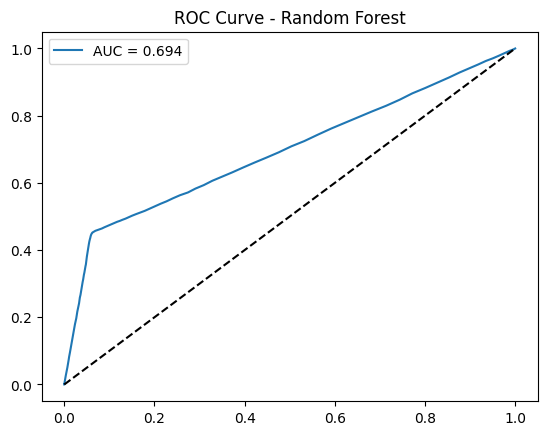

In [13]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# ROC Curve
y_pred_proba = classifier.predict_proba(X_test_)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)



plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title("ROC Curve - Random Forest")
plt.show()


# Accuracy --> 0.8246
# AUC Score --> 0.694

# Hyperparameter Tuning using GridSearch

In [14]:
# Adding Class_weight --> balanced and doing grid search

In [14]:
# -----------------------------------
# Hyperparameter Tuning for Random Forest
# -----------------------------------
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'criterion': ['entropy'],
    'class_weight': ['balanced', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,          # Use all CPU cores
    verbose=2,
    scoring='roc_auc'   # Optimize for AUC score
)


In [15]:
# Fit the model on training data
grid_search.fit(X_train_, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score (CV):", grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best AUC Score (CV): 0.6969894954048463


In [16]:
# Evaluate the best model on test data
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
accuracy = accuracy_score(y_test, y_pred_best)
auc_test = roc_auc_score(y_test, best_rf.predict_proba(X_test_)[:, 1])

print("\nFinal Model Accuracy:", accuracy)
print("Final AUC:", auc_test)
print(classification_report(y_test, y_pred_best))


Final Model Accuracy: 0.8271153927528668
Final AUC: 0.6984628887125381
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     54452
           1       0.70      0.45      0.55     16445

    accuracy                           0.83     70897
   macro avg       0.77      0.70      0.72     70897
weighted avg       0.81      0.83      0.81     70897



In [18]:
print(grid_search.best_params_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


# 2. Threshold Tuning

The default classification threshold of 0.50 is not suitable for this imbalanced medical dataset. 
A lower threshold improves the detection of malignant cases, reducing false negatives. 
After obtaining the predicted probabilities from the model, multiple thresholds (0.25, 0.30, 0.40) were tested.
A custom threshold was applied to convert probabilities into class labels. This approach increased recall and sensitivity for the malignant class,
which is clinically more important than overall accuracy. The optimal threshold was also identified using the ROC curve.

In [19]:
# -----------------------------------
y_proba = best_rf.predict_proba(X_test_)[:, 1]
threshold = 0.30
y_pred_custom = (y_proba >= threshold).astype(int)

print("\nConfusion Matrix (Threshold Tuned):\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report (Threshold Tuned):\n", classification_report(y_test, y_pred_custom))
print("AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix (Threshold Tuned):
 [[51209  3243]
 [ 9014  7431]]

Classification Report (Threshold Tuned):
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     54452
           1       0.70      0.45      0.55     16445

    accuracy                           0.83     70897
   macro avg       0.77      0.70      0.72     70897
weighted avg       0.81      0.83      0.81     70897

AUC Score: 0.6984628887125381


# Important Metric to be evaluated for this project is Recall for class 1 (Malignant class)

Here Recall for Malignant is 0.45 .
f1-score for Malignant is 0.55.
High recall → fewer missed cancer cases.
So to improve Recall value, trying to tune the threshold value

In [21]:
# -----------------------------------
y_proba = best_rf.predict_proba(X_test_)[:, 1]
threshold = 0.20
y_pred_custom = (y_proba >= threshold).astype(int)

print("\nConfusion Matrix (Threshold Tuned):\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report (Threshold Tuned):\n", classification_report(y_test, y_pred_custom))
print("AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix (Threshold Tuned):
 [[51154  3298]
 [ 9003  7442]]

Classification Report (Threshold Tuned):
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     54452
           1       0.69      0.45      0.55     16445

    accuracy                           0.83     70897
   macro avg       0.77      0.70      0.72     70897
weighted avg       0.81      0.83      0.81     70897

AUC Score: 0.6984628887125381


In [22]:
# -----------------------------------
y_proba = best_rf.predict_proba(X_test_)[:, 1]
threshold = 0.25
y_pred_custom = (y_proba >= threshold).astype(int)

print("\nConfusion Matrix (Threshold Tuned):\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report (Threshold Tuned):\n", classification_report(y_test, y_pred_custom))
print("AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix (Threshold Tuned):
 [[51200  3252]
 [ 9014  7431]]

Classification Report (Threshold Tuned):
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     54452
           1       0.70      0.45      0.55     16445

    accuracy                           0.83     70897
   macro avg       0.77      0.70      0.72     70897
weighted avg       0.81      0.83      0.81     70897

AUC Score: 0.6984628887125381


In [31]:
# -----------------------------------
y_proba = best_rf.predict_proba(X_test_)[:, 1]
threshold = 0.16
y_pred_custom = (y_proba >= threshold).astype(int)

print("\nConfusion Matrix (Threshold Tuned):\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report (Threshold Tuned):\n", classification_report(y_test, y_pred_custom))
print("AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix (Threshold Tuned):
 [[46808  7644]
 [ 8183  8262]]

Classification Report (Threshold Tuned):
               precision    recall  f1-score   support

           0       0.85      0.86      0.86     54452
           1       0.52      0.50      0.51     16445

    accuracy                           0.78     70897
   macro avg       0.69      0.68      0.68     70897
weighted avg       0.77      0.78      0.78     70897

AUC Score: 0.6984628887125381


At a threshold of 0.16, the malignant recall increased from 0.43 (baseline) to 0.50, meaning the model identified more cancer cases while maintaining acceptable precision (0.52). Although accuracy slightly decreased (from 0.82 to 0.78), this is appropriate for healthcare applications where missing malignant cases is more critical than generating false positives.

# Saving the Model

In [20]:
# best model
print (best_rf)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       random_state=42)


In [21]:
import pickle

pickle.dump(best_rf, open(r"E:\AI Course\Week - 9 - ML and Data Science Capstone\4. Feature Selection & Model Creation/final_thyroid_risk_model.pkl", "wb"))


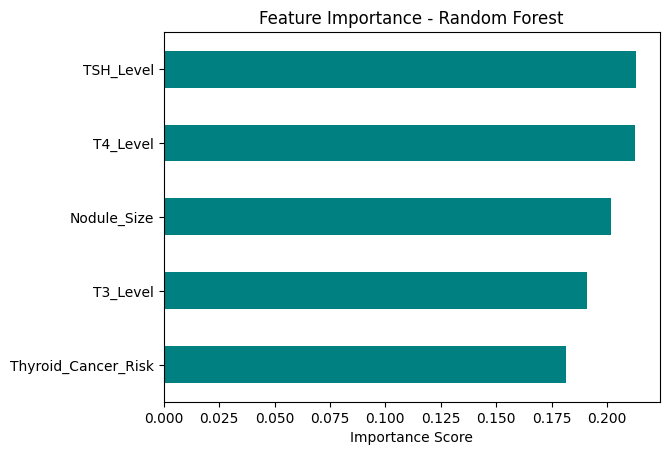

In [12]:
# Feature Importance Plot
# -------------------------
importances = pd.Series(classifier.feature_importances_, index= ['Thyroid_Cancer_Risk', 'TSH_Level', 'T4_Level', 'Nodule_Size', 'T3_Level'])
importances.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()